<a href="https://colab.research.google.com/github/n-goyal/python-test/blob/master/Stock_Market_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### tools

In [0]:
#Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import date

In [4]:
#data collection
!pip install nsepy
from nsepy import get_history

  Stored in directory: /root/.cache/pip/wheels/88/89/1e/3dfa14f863314a42481d8926d9ef4825da5d899e026435fc3a
Successfully built nsepy


### Data collection

In [0]:
tcs_data = get_history(symbol='TCS',
                    start=date(2018,4,1), 
                    end=date(2019,2,28))

infy_data = get_history(symbol='INFY',
                    start=date(2018,4,1), 
                    end=date(2019,2,28))

In [186]:
infy_data.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2018-04-02,INFY,EQ,1131.80,1141.00,1149.55,1121.3,1136.70,1137.15,1135.86,4036351,4.584717e+14,142078,2960225,0.7334
2018-04-03,INFY,EQ,1137.15,1134.70,1143.55,1128.1,1139.40,1140.45,1135.21,2038584,2.314227e+14,114034,1366638,0.6704
2018-04-04,INFY,EQ,1140.45,1144.00,1144.55,1120.0,1122.70,1124.20,1131.81,2406651,2.723879e+14,137029,1472105,0.6117
2018-04-05,INFY,EQ,1124.20,1139.55,1151.30,1129.1,1146.05,1147.55,1140.71,3881772,4.427993e+14,101745,2899162,0.7469
2018-04-06,INFY,EQ,1147.55,1143.00,1146.00,1122.1,1127.55,1127.00,1128.81,2968871,3.351285e+14,137277,1891236,0.6370


In [0]:
#dropping irrelavent columns
def drop(data):
  return data.drop(['Symbol', 'Series', 'Open', 'High', 'Low', 'Last', 'VWAP', 'Turnover', 'Trades', '%Deliverble', 'Deliverable Volume', 'Prev Close'], axis = 1)

In [0]:
tcs = drop(tcs_data)
infy = drop(infy_data)

In [189]:
tcs.head()

,Close,Volume
Date,,
2018-04-02,2909.65,831494
2018-04-03,2911.25,968645
2018-04-04,2910.90,1420910
2018-04-05,2957.95,904712
2018-04-06,2950.30,564509


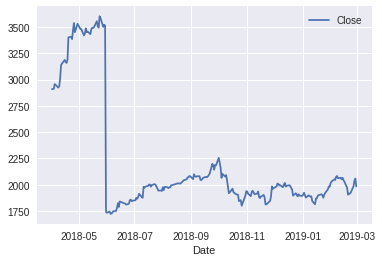

In [190]:
plt.figure()
tcs['Close'].plot()
plt.legend()

###Volume Shock, Price Shock - Dummy time series

In [0]:
# Time to add some new columns
# volume_shock = Volume - Prev Volume
# Percentage_Volume_shock = volume_shock / Prev Volume * 100
# price_shock = Close - Prev Close
# Percentage_close = price_shock / Prev Close * 100

In [0]:
tcs = tcs_data
infy = infy_data

In [0]:
#checking on the shock percentage
def volume_shock(data): 
  data['Volume_diff'] = data['Volume'].diff(1)
  return data['Volume'].diff(1) / data['Volume'] * 100
  
def price_shock(data):
  data['Price_diff'] = data['Close'].diff(1)
  return data['Close'].diff(1) / data['Close'] * 100

def dummy(data):
#   drop(data)
  data['Volume_shock'] = [1 if abs(i)>0 else 0 for i in volume_shock(data)]
  data['Price_shock'] = [1 if abs(i)>2 else 0 for i in price_shock(data)]
  data['PriceV/Svolume'] = [1 if (data['Volume_shock'][i]==0 and data['Price_shock'][i]==1) 
                            else 0 for i in range(len(price_shock(data)))]

In [196]:
dummy(tcs)
tcs.head()

,Close,Volume,Volume_shock,Price_shock,PriceV/Svolume,Volume_diff,Price_diff
Date,,,,,,,
2018-04-02,2909.65,831494,0,0,0,NaN,NaN
2018-04-03,2911.25,968645,1,0,0,137151.0,1.60
2018-04-04,2910.90,1420910,1,0,0,452265.0,-0.35
2018-04-05,2957.95,904712,1,0,0,-516198.0,47.05
2018-04-06,2950.30,564509,1,0,0,-340203.0,-7.65


In [0]:
#direction of shock
# def direction(name):
#   if data['{}_shock'.format(name)] == 0:
#     pass
#   else:
#     if (data['{}_diff'.format(name)]<0):
#       return 0
#     else:
#       return 1

In [0]:
# def vol_shock_dir(data, name):
#   data['Volume_shock_direction'] = direction(name)
#   return data

In [0]:
# tcs = vol_shock_dir(tcs, 'Volume')

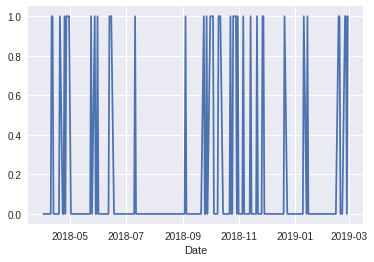

In [21]:
tcs['%Price_shock_dummy'].plot()

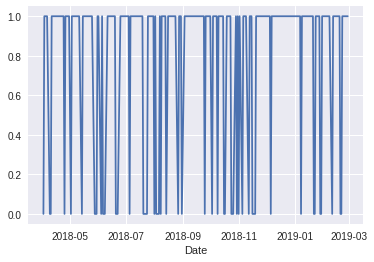

In [0]:
tcs['%Volume_shock_dummy'].plot()

### Moving Averages

In [0]:
tcs = tcs_data
tcs = drop(tcs)

In [34]:
tcs.isna().sum()

Close     0
Volume    0
dtype: int64

In [0]:
# Moving Window Average Function
def moving_avg(data, num_weeks):
  
  for i in range(4):
    window = data['Close'].rolling(window=num_weeks*7*(i+1),  
                                   center = False,
                                   min_periods=1)
    #averaging over the window
    data['window_'+str(num_weeks*(i+1))] = window.mean()

In [44]:
moving_avg(tcs, 4)
tcs.tail()

,Close,Volume,window_4,window_8,window_12,window_16
Date,,,,,,
2019-02-22,1925.65,2271955,1976.344643,1951.609821,1937.077381,1965.526786
2019-02-25,1985.15,2934880,1980.451786,1951.475000,1938.650595,1964.981250
2019-02-26,2038.70,6453309,1985.608929,1952.251786,1941.502976,1964.934375
2019-02-27,2058.10,4732082,1991.232143,1953.721429,1943.730357,1964.869196
2019-02-28,1983.45,8454295,1993.901786,1953.425893,1944.785714,1964.059375


In [37]:
tcs.isna().sum()

Close        0
Volume       0
window_4     0
window_8     0
window_12    0
window_16    0
dtype: int64

In [31]:
tcs.shape

(229, 6)

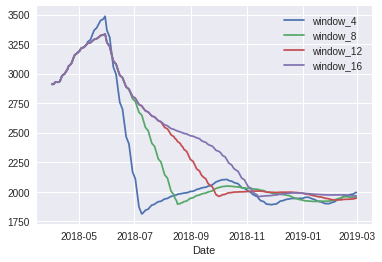

In [38]:
plt.figure()
tcs['window_4'].plot()
tcs['window_8'].plot()
tcs['window_12'].plot()
tcs['window_16'].plot()
plt.legend()

In [0]:
tcs['window10'] = tcs['Close'].rolling(window=10, center=False, min_periods = 1).mean()
tcs['window75'] = tcs['Close'].rolling(window=75, center=False, min_periods = 1).mean()

In [47]:
tcs.head()
#As we can see that out of a year(almost) the stock market was working only for 229 days.
#this incorporates a discrepancy in rolling window because the holidays have not considered.

,Close,Volume,window_4,window_8,window_12,window_16,window10,window75
Date,,,,,,,,
2018-04-02,2909.65,831494,2909.6500,2909.6500,2909.6500,2909.6500,2909.6500,2909.6500
2018-04-03,2911.25,968645,2910.4500,2910.4500,2910.4500,2910.4500,2910.4500,2910.4500
2018-04-04,2910.90,1420910,2910.6000,2910.6000,2910.6000,2910.6000,2910.6000,2910.6000
2018-04-05,2957.95,904712,2922.4375,2922.4375,2922.4375,2922.4375,2922.4375,2922.4375
2018-04-06,2950.30,564509,2928.0100,2928.0100,2928.0100,2928.0100,2928.0100,2928.0100


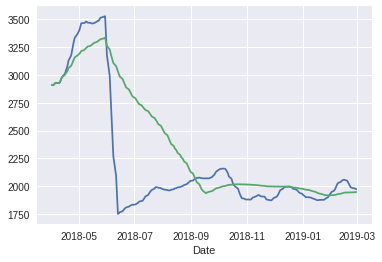

In [50]:
tcs['window10'].plot()
tcs['window75'].plot()

### Moving Average (Window = 10, 75) - considering holidays

In [0]:
tcs = tcs_data
infy = infy_data
stocks = [tcs, infy]

In [0]:
def dates(data):
  data['Date'] = pd.to_datetime(data.index)
  data['#Week'] = data.Date.dt.weekofyear
  return data
  
#dropping irrelavent columns
def drop(data):
  return data.drop(['Symbol', 
                    'Series', 
                    'Open', 
                    'High', 
                    'Low', 
                    'Last', 
                    'VWAP', 
                    'Turnover', 
                    'Trades', 
                    '%Deliverble', 
                    'Deliverable Volume', 
                    'Prev Close'], axis = 1)

def format_data(data):
  df = drop(data)
  data = dates(df)
  return data

In [0]:
tcs = format_data(tcs)
infy = format_data(infy)

In [155]:
tcs.tail()

,Close,Volume,Date,#Week
Date,,,,
2019-02-22,1925.65,2271955,2019-02-22,8
2019-02-25,1985.15,2934880,2019-02-25,9
2019-02-26,2038.70,6453309,2019-02-26,9
2019-02-27,2058.10,4732082,2019-02-27,9
2019-02-28,1983.45,8454295,2019-02-28,9


In [0]:
# task: rolling mean with window = [10, 75]
# rolling window w/o resampling is throwing nans and doesn't considering the holidays
# Resamping with frequency with Dates
def plot_roll_window(stock, window, stock_name):
  stock = stock.asfreq('D', method='ffill')
  stock['Window '+str(window)] = stock['Close'].rolling(window).mean()
  plt.figure()
  stock['Window '+str(window)].plot()
  plt.title('roll avg for {0} with window = {1} Days'.format(stock_name, window))
  plt.legend()
  return stock

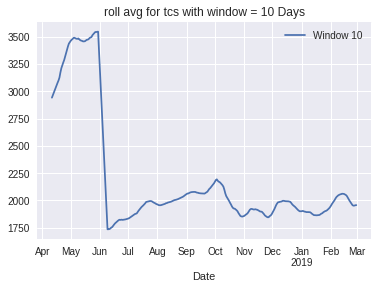

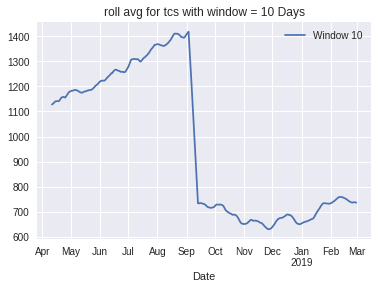

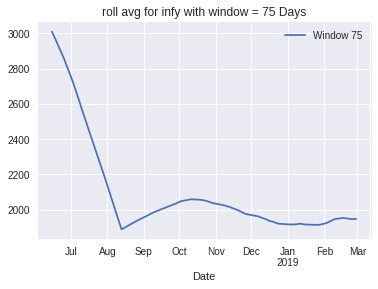

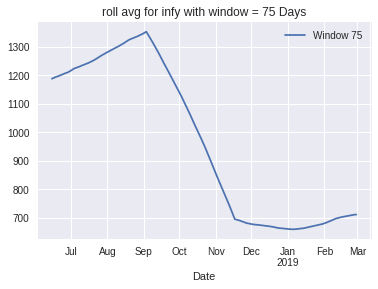

In [157]:
window = [10, 75]
stock = [tcs, infy]
stocks_name = ['tcs', 'infy']
for i in range(len(window)):
  for j in range(len(stocks)):
#     print('roll avg for {0} with window = {1} Days'.format(stocks_name[j], window[i]))
    plot_roll_window(stock[j], window[i], stocks_name[i])
#   print('roll avg for infy with window = ' + str(i) + ' Days')
#   plot_roll_window(infy, i)